# Day 9
batch size 256 lr 5e-3, normed weighted, non-rotated, cartesian, rotation augmentation

### Import modules

In [1]:
%matplotlib inline
from __future__ import division
import sys
import os
os.environ['MKL_THREADING_LAYER']='GNU'
sys.path.append('../')
from Modules.Basics import *
from Modules.Class_Basics import *

/home/giles/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/giles/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
Using TensorFlow backend.


## Options

In [2]:
classTrainFeatures = ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_met_pt', 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_all_pt', 'PRI_tau_px', 'PRI_tau_py', 'PRI_tau_pz', 'PRI_lep_px', 'PRI_lep_py', 'PRI_lep_pz', 'PRI_jet_leading_px', 'PRI_jet_leading_py', 'PRI_jet_leading_pz', 'PRI_jet_subleading_px', 'PRI_jet_subleading_py', 'PRI_jet_subleading_pz', 'PRI_met_px', 'PRI_met_py']
classModel = 'modelSwish'
varSet = "basic_features"

nSplits = 10
ensembleSize = 10
ensembleMode = 'loss'

maxEpochs = 200
compileArgs = {'loss':'binary_crossentropy', 'optimizer':'adam'}
trainParams = {'epochs' : 1, 'batch_size' : 256, 'verbose' : 0}
modelParams = {'version':classModel, 'nIn':len(classTrainFeatures), 'compileArgs':compileArgs, 'mode':'classifier'}

print "\nTraining on", len(classTrainFeatures), "features:", [var for var in classTrainFeatures]


Training on 31 features: ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_met_pt', 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_all_pt', 'PRI_tau_px', 'PRI_tau_py', 'PRI_tau_pz', 'PRI_lep_px', 'PRI_lep_py', 'PRI_lep_pz', 'PRI_jet_leading_px', 'PRI_jet_leading_py', 'PRI_jet_leading_pz', 'PRI_jet_subleading_px', 'PRI_jet_subleading_py', 'PRI_jet_subleading_pz', 'PRI_met_px', 'PRI_met_py']


## Import data

In [3]:
class RotationBatch(BatchYielder):
    def __init__(self, header, datafile=None, augMult=8, trainTimeAug=True, testTimeAug=True):
        self.header = header
        self.augmented = True
        self.augMult = augMult
        self.trainTimeAug = trainTimeAug
        self.testTimeAug = testTimeAug
        if not isinstance(datafile, types.NoneType):
            self.addSource(datafile)
    
    @staticmethod
    def rotate(inData):
        vectors = [x[:-3] for x in inData.columns if '_px' in x]
        for vector in vectors:
            inData.loc[:, vector + '_px'] = inData.loc[:, vector + '_px']*np.cos(inData.loc[:, 'aug_angle'])-inData.loc[:, vector + '_py']*np.sin(inData.loc[:, 'aug_angle'])
            inData.loc[:, vector + '_py'] = inData.loc[:, vector + '_py']*np.cos(inData.loc[:, 'aug_angle'])+inData.loc[:, vector + '_px']*np.sin(inData.loc[:, 'aug_angle'])
                
    def getBatch(self, index, datafile=None):
        if isinstance(datafile, types.NoneType):
            datafile = self.source
            
        index = str(index)
        weights = None
        targets = None
        if 'fold_' + index + '/weights' in datafile:
            weights = np.array(datafile['fold_' + index + '/weights'])
        if 'fold_' + index + '/targets' in datafile:
            targets = np.array(datafile['fold_' + index + '/targets'])

        inputs = pandas.DataFrame(np.array(datafile['fold_' + index + '/inputs']), columns=self.header)
        inputs['aug_angle'] = 2*np.pi*np.random.random(size=len(inputs))
        self.rotate(inputs)
        
        return {'inputs':inputs[self.header].values,
                'targets':targets,
                'weights':weights}
    
    def getTestBatch(self, index, augIndex, datafile=None):
        if augIndex >= self.augMult:
            print "Invalid augmentation index passed", augIndex
            return -1
        
        if isinstance(datafile, types.NoneType):
            datafile = self.source
            
        index = str(index)
        weights = None
        targets = None
        if 'fold_' + index + '/weights' in datafile:
            weights = np.array(datafile['fold_' + index + '/weights'])
        if 'fold_' + index + '/targets' in datafile:
            targets = np.array(datafile['fold_' + index + '/targets'])
            
        inputs = pandas.DataFrame(np.array(datafile['fold_' + index + '/inputs']), columns=self.header)
        inputs['aug_angle'] = np.linspace(0, 2*np.pi, self.augMult+1)[augIndex]
        self.rotate(inputs)

        return {'inputs':inputs[self.header].values,
                'targets':targets,
                'weights':weights}

In [4]:
trainData = RotationBatch(classTrainFeatures, h5py.File(dirLoc + 'train.hdf5', "r+"))
valData = RotationBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"))

## Determine LR

2 classes found, running in binary mode


______________________________________
Training finished
Cross-validation took 1.161s 


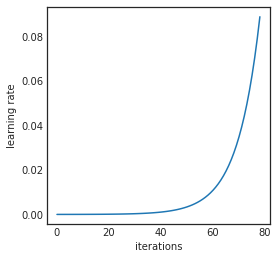

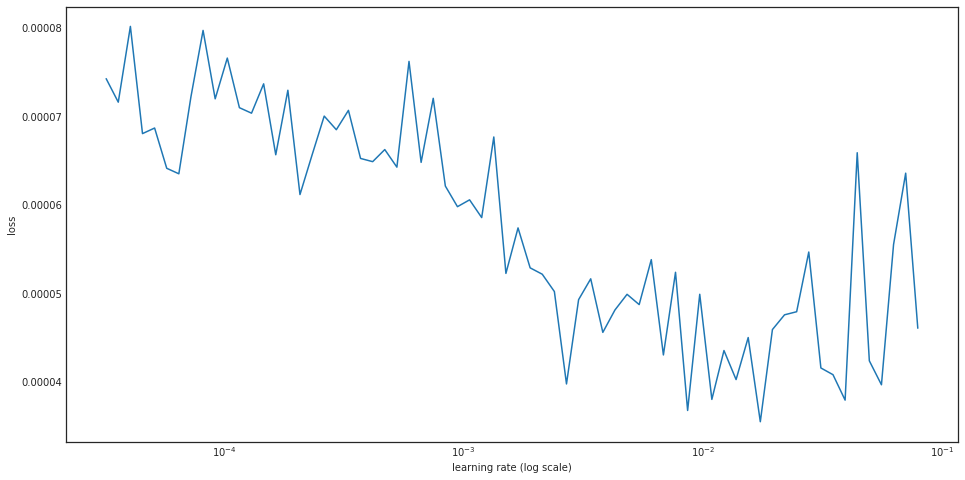

______________________________________



In [5]:
lrFinder = batchLRFind(trainData, getModel, modelParams, trainParams,
                       lrBounds=[1e-5,1e-1], trainOnWeights=True, verbose=0)

In [6]:
compileArgs['lr'] = 5e-3

## Train classifier

Using cosine annealing
Training using weights
Running fold 1 / 10
2 classes found, running in binary mode

1 New best found: 3.79040078472e-05
2 New best found: 3.64228218716e-05
3 New best found: 3.5278827263e-05
5 New best found: 3.47593694308e-05
6 New best found: 3.42880374814e-05
7 New best found: 3.38969217882e-05
12 New best found: 3.37007679465e-05
13 New best found: 3.33454580003e-05
14 New best found: 3.32488795045e-05
23 New best found: 3.32463696193e-05
24 New best found: 3.30338729719e-05
26 New best found: 3.27841262981e-05
28 New best found: 3.2550036154e-05
30 New best found: 3.24586403755e-05
31 New best found: 3.24205196721e-05
53 New best found: 3.23192389154e-05
59 New best found: 3.22309930099e-05
60 New best found: 3.21654900836e-05
114 New best found: 3.21543619176e-05
120 New best found: 3.21471504653e-05
121 New best found: 3.21197842587e-05
122 New best found: 3.21135910816e-05
125 New best found: 3.20988386911e-05
127 New best found: 3.20742736667e-05
Early s

/home/giles/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.103075). Check your callbacks.
  % delta_t_median)


1 New best found: 3.7299460316e-05
2 New best found: 3.57370113617e-05
3 New best found: 3.41984567751e-05
6 New best found: 3.36126942614e-05
11 New best found: 3.33191640571e-05
12 New best found: 3.31972880308e-05
13 New best found: 3.27206526824e-05
23 New best found: 3.27048638743e-05
25 New best found: 3.25658399372e-05
26 New best found: 3.24875414e-05
27 New best found: 3.2375125279e-05
28 New best found: 3.2195102497e-05
30 New best found: 3.20019331836e-05
50 New best found: 3.19931997773e-05
52 New best found: 3.19907240938e-05
54 New best found: 3.19401556997e-05
55 New best found: 3.19234614077e-05
57 New best found: 3.17779738808e-05
58 New best found: 3.16517205959e-05
Early stopping after 127 epochs
Score is: {'loss': 3.165172059585499e-05, 'AUC': 0.10036053666304234, 'wAUC': 0.06312401120210875}
Fold took 132.004s

Running fold 5 / 10
1 New best found: 3.74232079832e-05
2 New best found: 3.56219122105e-05
3 New best found: 3.46460925815e-05
6 New best found: 3.38485434

/home/giles/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.152810). Check your callbacks.
  % delta_t_median)


1 New best found: 3.80997783136e-05
2 New best found: 3.75078758106e-05
3 New best found: 3.6052772681e-05
5 New best found: 3.56475978506e-05
6 New best found: 3.43925441714e-05
7 New best found: 3.43518874962e-05
10 New best found: 3.43286449141e-05
11 New best found: 3.41421903926e-05
12 New best found: 3.36324617326e-05
13 New best found: 3.34471804286e-05
14 New best found: 3.34201809268e-05
15 New best found: 3.32693334015e-05
24 New best found: 3.31742376468e-05
26 New best found: 3.30748871766e-05
27 New best found: 3.27127870496e-05
28 New best found: 3.26309674364e-05
29 New best found: 3.25436554269e-05
30 New best found: 3.2502059159e-05
54 New best found: 3.22445484199e-05
60 New best found: 3.21814901484e-05
100 New best found: 3.21722421135e-05
107 New best found: 3.21038495092e-05
108 New best found: 3.20796016212e-05
114 New best found: 3.20679577963e-05
116 New best found: 3.19799145392e-05
117 New best found: 3.19524536925e-05
Early stopping after 255 epochs
Score is

/home/giles/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.148393). Check your callbacks.
  % delta_t_median)


1 New best found: 3.77092844258e-05
2 New best found: 3.59660214215e-05
3 New best found: 3.51511772247e-05
5 New best found: 3.50537697479e-05
6 New best found: 3.43015872029e-05
7 New best found: 3.38203250835e-05
13 New best found: 3.34485999337e-05
14 New best found: 3.30106630786e-05
24 New best found: 3.29995516441e-05
26 New best found: 3.2791552276e-05
27 New best found: 3.27093754421e-05
28 New best found: 3.24973009044e-05
29 New best found: 3.24692803692e-05
30 New best found: 3.23850748173e-05
31 New best found: 3.23715771342e-05
51 New best found: 3.23500401594e-05
52 New best found: 3.23105867981e-05
55 New best found: 3.20446725398e-05
61 New best found: 3.2029806317e-05
62 New best found: 3.19901084788e-05
107 New best found: 3.19561546225e-05
109 New best found: 3.18713683944e-05
116 New best found: 3.1850053331e-05
117 New best found: 3.18208668622e-05
119 New best found: 3.17148767048e-05
Early stopping after 255 epochs
Score is: {'loss': 3.1714876704810116e-05, 'AUC

/home/giles/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.142901). Check your callbacks.
  % delta_t_median)


1 New best found: 3.77339414799e-05
2 New best found: 3.57779453284e-05
3 New best found: 3.50369083844e-05
5 New best found: 3.45741766437e-05
6 New best found: 3.43314805265e-05
7 New best found: 3.40475286421e-05
12 New best found: 3.37403780014e-05
13 New best found: 3.33351239516e-05
14 New best found: 3.31089958233e-05
25 New best found: 3.30449938887e-05
26 New best found: 3.28906314189e-05
27 New best found: 3.27223180199e-05
28 New best found: 3.26304497682e-05
29 New best found: 3.24890071218e-05
31 New best found: 3.24704325795e-05
54 New best found: 3.24415371165e-05
55 New best found: 3.2334034033e-05
57 New best found: 3.23265839383e-05
58 New best found: 3.224925353e-05
59 New best found: 3.21650080405e-05
60 New best found: 3.21607963656e-05
62 New best found: 3.21170374686e-05
Early stopping after 127 epochs
Score is: {'loss': 3.211703746856947e-05, 'AUC': 0.10604338890940879, 'wAUC': 0.06521465430240414}
Fold took 133.915s

Running fold 9 / 10


/home/giles/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174770). Check your callbacks.
  % delta_t_median)


1 New best found: 3.71719954086e-05
2 New best found: 3.60624748457e-05
3 New best found: 3.55337345388e-05
6 New best found: 3.44334246543e-05
7 New best found: 3.43810055889e-05
12 New best found: 3.406796428e-05
13 New best found: 3.37769047888e-05
14 New best found: 3.37505883879e-05
15 New best found: 3.35802447257e-05
26 New best found: 3.34125258142e-05
28 New best found: 3.33315178475e-05
29 New best found: 3.32608792159e-05
30 New best found: 3.32117161747e-05
31 New best found: 3.31464992069e-05
54 New best found: 3.30901571868e-05
56 New best found: 3.29335419956e-05
57 New best found: 3.28906544255e-05
58 New best found: 3.28591414978e-05
59 New best found: 3.28585517322e-05
61 New best found: 3.27521989564e-05
106 New best found: 3.27458494077e-05
117 New best found: 3.27371129202e-05
120 New best found: 3.27212335466e-05
122 New best found: 3.26869929804e-05
Early stopping after 255 epochs
Score is: {'loss': 3.268699298035663e-05, 'AUC': 0.10163866402548893, 'wAUC': 0.066

/home/giles/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235974). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.118245). Check your callbacks.
  % delta_t_median)


1 New best found: 3.84435909615e-05
2 New best found: 3.60689255188e-05
3 New best found: 3.55490495286e-05
5 New best found: 3.46937446553e-05
6 New best found: 3.44857537204e-05
7 New best found: 3.39551448214e-05
13 New best found: 3.36114066066e-05
14 New best found: 3.35114009755e-05
15 New best found: 3.3358296967e-05
25 New best found: 3.33146717219e-05
26 New best found: 3.32618649214e-05
27 New best found: 3.3041036248e-05
28 New best found: 3.28321476065e-05
30 New best found: 3.27500579752e-05
49 New best found: 3.26815367084e-05
55 New best found: 3.25764607527e-05
57 New best found: 3.25658599448e-05
58 New best found: 3.25435063807e-05
59 New best found: 3.23686877334e-05
61 New best found: 3.23548021127e-05
Early stopping after 127 epochs
Score is: {'loss': 3.235480211272975e-05, 'AUC': 0.09987085137190921, 'wAUC': 0.06594132581489087}
Fold took 135.680s


______________________________________
Training finished
Cross-validation took 2480.475s 


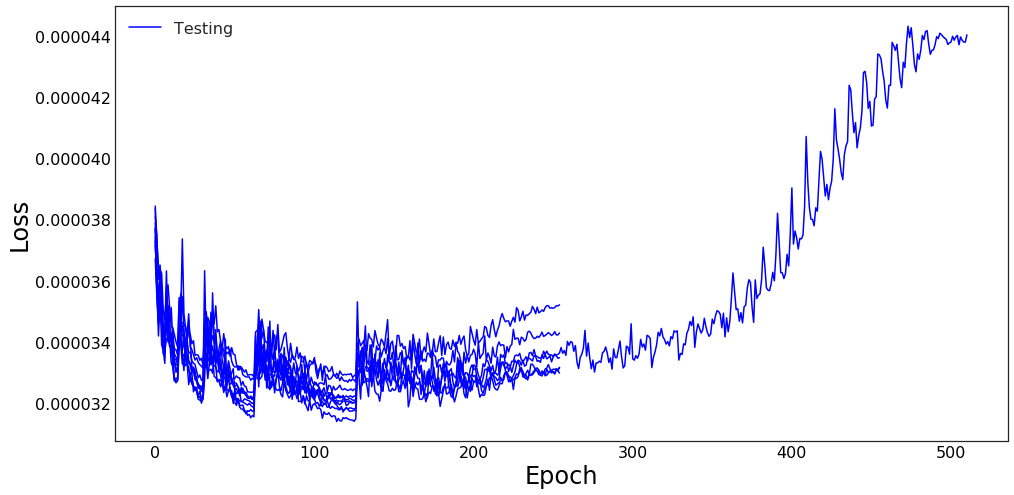

Mean wAUC = 0.0646 +- 0.0005
______________________________________



In [7]:
results, histories = batchTrainClassifier(trainData, nSplits, getModel, modelParams, trainParams,
                                          patience=2, cosAnnealMult=2, trainOnWeights=True,
                                          maxEpochs=maxEpochs, verbose=1)

## Construct ensemble

In [8]:
with open('train_weights/resultsFile.pkl', 'r') as fin:   
    results = pickle.load(fin)

In [9]:
ensemble, weights = assembleEnsemble(results, ensembleSize, ensembleMode, compileArgs)

Choosing ensemble by loss
Model 0 is 1 with loss = 3.1402001663302934e-05
Model 1 is 3 with loss = 3.165172059585499e-05
Model 2 is 6 with loss = 3.1714876704810116e-05
Model 3 is 4 with loss = 3.1854294612842535e-05
Model 4 is 5 with loss = 3.1952453692475605e-05
Model 5 is 0 with loss = 3.207427366667504e-05
Model 6 is 7 with loss = 3.211703746856947e-05
Model 7 is 9 with loss = 3.235480211272975e-05
Model 8 is 8 with loss = 3.268699298035663e-05
Model 9 is 2 with loss = 3.284286459150897e-05


In [10]:
np.mean([])

/home/giles/anaconda2/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/giles/anaconda2/lib/python2.7/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


nan

## Response on development data

In [12]:
def batchEnsemblePredict(ensemble, weights, data, predName='pred', nOut=1, outputPipe=None, ensembleSize=None, nFolds=-1, verbose=False):
    if isinstance(ensembleSize, types.NoneType):
        ensembleSize = len(ensemble)

    if not isinstance(data, BatchYielder):
        data = BatchYielder(data)

    if nFolds < 0:
        nFolds = len(data.source)

    for fold in range(nFolds):
        if verbose:
            print 'Predicting batch {} out of {}'.format(fold+1, nFolds)
            start = timeit.default_timer()

        if not data.testTimeAug:
            batch = data.getBatch(fold)['inputs']
            batchPred = ensemblePredict(batch, ensemble, weights, n=ensembleSize, nOut=nOut, outputPipe=outputPipe)

        else:
            tmpPred = []
            for aug in range(data.augMult):
                batch = data.getTestBatch(fold, aug)['inputs']
                tmpPred.append(ensemblePredict(batch, ensemble, weights, n=ensembleSize, nOut=nOut, outputPipe=outputPipe))
            batchPred = np.mean(tmpPred, axis=0)

        if verbose: 
            print "Prediction took {}s per sample\n".format((timeit.default_timer() - start)/len(batch))

        if nOut > 1:
            saveBatchPred(batchPred, 'fold_' + str(fold), data.source, predName=predName)
        else:
            saveBatchPred(batchPred[:,0], 'fold_' + str(fold), data.source, predName=predName)

In [13]:
batchEnsemblePredict(ensemble, weights, trainData, ensembleSize=10, verbose=1)

Predicting batch 1 out of 10
Prediction took 0.00231865795664s per sample

Predicting batch 2 out of 10
Prediction took 0.00203936382876s per sample

Predicting batch 3 out of 10
Prediction took 0.00211811639042s per sample

Predicting batch 4 out of 10
Prediction took 0.00216780714989s per sample

Predicting batch 5 out of 10
Prediction took 0.00214516779184s per sample

Predicting batch 6 out of 10
Prediction took 0.0020678366065s per sample

Predicting batch 7 out of 10
Prediction took 0.00207335600853s per sample

Predicting batch 8 out of 10
Prediction took 0.00205691985306s per sample

Predicting batch 9 out of 10
Prediction took 0.00212082834719s per sample

Predicting batch 10 out of 10
Prediction took 0.00209002269734s per sample



In [14]:
print 'Training ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', trainData.source), getFeature('pred', trainData.source)),
                                                            roc_auc_score(getFeature('targets', trainData.source), getFeature('pred', trainData.source), sample_weight=getFeature('weights', trainData.source)))

Training ROC AUC: unweighted 0.904783288719, weighted 0.940640609578


## Response on val data

In [15]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=10, verbose=1)

Predicting batch 1 out of 10
Prediction took 0.00207479043007s per sample

Predicting batch 2 out of 10
Prediction took 0.00206748518944s per sample

Predicting batch 3 out of 10
Prediction took 0.00209967398643s per sample

Predicting batch 4 out of 10
Prediction took 0.00205588879585s per sample

Predicting batch 5 out of 10
Prediction took 0.00211500840187s per sample

Predicting batch 6 out of 10
Prediction took 0.00202868762016s per sample

Predicting batch 7 out of 10
Prediction took 0.00211792140007s per sample

Predicting batch 8 out of 10
Prediction took 0.00206067757607s per sample

Predicting batch 9 out of 10
Prediction took 0.00201144576073s per sample

Predicting batch 10 out of 10
Prediction took 0.00212015080452s per sample



In [16]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

Testing ROC AUC: unweighted 0.901771555067, weighted 0.935092407904


## Evaluation

### Import in dataframe

In [17]:
valframe = convertToDF(valData.source)

50000 candidates loaded


In [18]:
sigVal = (valframe.gen_target == 1)
bkgVal = (valframe.gen_target == 0)

### MVA distributions

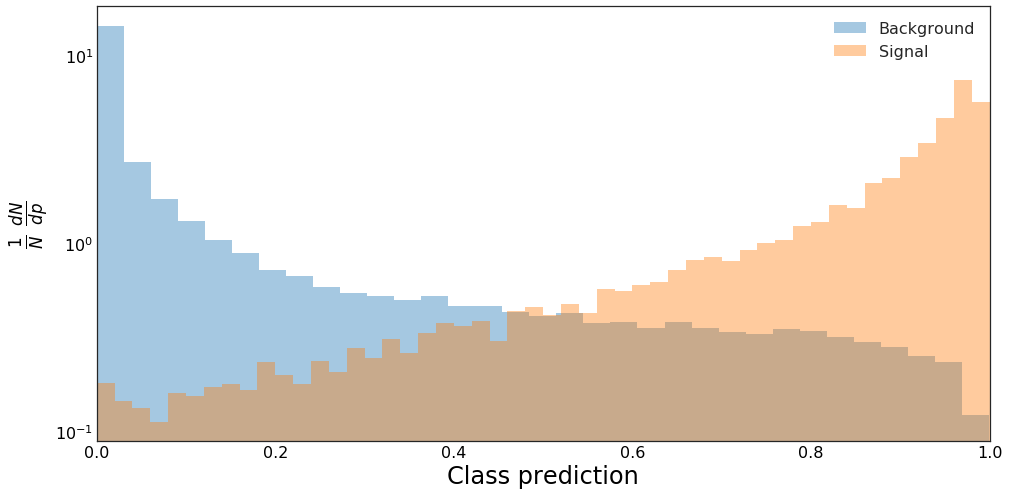

In [19]:
getClassPredPlot([valframe[bkgVal], valframe[sigVal]], weightName='gen_weight')

In [20]:
valframe['ams'] = amsScan(valframe)[0]

[0.9579285383224487, 1.6960349835778525]


In [21]:
bests = foldAMSScan(valframe, 10)

[0.9857715964317322, 2.02567152387413]
Fold 0, best AMS 2.02567152387 at cut of 0.985771596432. Total weights Signal:Bkg. 13.991812706:8281.83789062


../Modules/Basics.py:63: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  np.sum(inData.iloc[test][inData.gen_target == 1]['gen_weight']),
../Modules/Basics.py:64: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  np.sum(inData.iloc[test][inData.gen_target == 0]['gen_weight']))


[0.9386342763900757, 1.784175602732194]
Fold 1, best AMS 1.78417560273 at cut of 0.93863427639. Total weights Signal:Bkg. 13.8332748413:8294.97070312
[0.9790675044059753, 2.2794273375888934]
Fold 2, best AMS 2.27942733759 at cut of 0.979067504406. Total weights Signal:Bkg. 13.6162910461:8171.09375
[0.9186940789222717, 1.5455121076740521]
Fold 3, best AMS 1.54551210767 at cut of 0.918694078922. Total weights Signal:Bkg. 13.77277565:8255.5078125
[0.9840020537376404, 2.024831370048734]
Fold 4, best AMS 2.02483137005 at cut of 0.984002053738. Total weights Signal:Bkg. 13.2541999817:8117.69482422
[0.9323616623878479, 1.7277692943298981]
Fold 5, best AMS 1.72776929433 at cut of 0.932361662388. Total weights Signal:Bkg. 13.715511322:8092.49121094
[0.978226900100708, 2.3146186167900296]
Fold 6, best AMS 2.31461861679 at cut of 0.978226900101. Total weights Signal:Bkg. 14.1896247864:8168.60742188
[0.9711857438087463, 1.9595192755810795]
Fold 7, best AMS 1.95951927558 at cut of 0.971185743809. T

In [22]:
batchEnsemblePredict(ensemble, weights, RotationBatch(classTrainFeatures, h5py.File(dirLoc + 'testing.hdf5', "r+")), ensembleSize=10, verbose=1)

Predicting batch 1 out of 10
Prediction took 0.00200742774443s per sample

Predicting batch 2 out of 10
Prediction took 0.00203859678182s per sample

Predicting batch 3 out of 10
Prediction took 0.00206853545362s per sample

Predicting batch 4 out of 10
Prediction took 0.00204988172705s per sample

Predicting batch 5 out of 10
Prediction took 0.00204623374939s per sample

Predicting batch 6 out of 10
Prediction took 0.00205763760047s per sample

Predicting batch 7 out of 10
Prediction took 0.00204184043624s per sample

Predicting batch 8 out of 10
Prediction took 0.0020513644912s per sample

Predicting batch 9 out of 10
Prediction took 0.00202667236328s per sample

Predicting batch 10 out of 10
Prediction took 0.00202495310957s per sample



In [28]:
saveTest(0.9595884326387787, 'Day_9_5e3_IM')

../Data/Day_9_5e3_IM_test.csv


In [29]:
!kaggle competitions submit -c higgs-boson -f ../Data/Day_9_5e3_IM_test.csv -m"Day_9 5e-3 IM"

Successfully submitted to Higgs Boson Machine Learning Challenge